### Download 1 year of 1 hour period stock data

In [1]:
import yfinance as yf
import pandas as pd

# Download NVDA stock data at 1-hour intervals for the past 1 year
df = yf.download(tickers='NVDA', period='1y', interval='1h', auto_adjust=True)

# Flatten columns if multi-indexed
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.get_level_values(0)

# Convert index (Datetime) from UTC to US/Eastern
df.index = df.index.tz_convert('US/Eastern')

# Preview the DataFrame
print(df.head())

# Optional: Save to CSV
df.to_csv('nvda_1y_1h_23_Aug_25.csv')

[*********************100%***********************]  1 of 1 completed

Price                           Close        High         Low        Open  \
Datetime                                                                    
2024-08-23 09:30:00-04:00  129.485001  129.600006  125.220001  125.870003   
2024-08-23 10:30:00-04:00  128.740005  129.580002  126.510002  129.479996   
2024-08-23 11:30:00-04:00  127.525002  129.179993  127.180000  128.770004   
2024-08-23 12:30:00-04:00  128.010605  128.149902  126.620003  127.510002   
2024-08-23 13:30:00-04:00  128.669998  128.779999  127.959999  128.020004   

Price                        Volume  
Datetime                             
2024-08-23 09:30:00-04:00  99471311  
2024-08-23 10:30:00-04:00  57004779  
2024-08-23 11:30:00-04:00  32240944  
2024-08-23 12:30:00-04:00  25570577  
2024-08-23 13:30:00-04:00  20085109  


### Filter out days without 7 data points

In [2]:
import pandas as pd

# Load CSV
df = pd.read_csv("nvda_1y_1h_23_Aug_25.csv")
df["Datetime"] = pd.to_datetime(df["Datetime"], utc=True)

# Add Date column
df["Date"] = df["Datetime"].dt.date

# Count per day
counts = df.groupby("Date").size()

# Keep only days with exactly 7 data points
valid_days = counts[counts == 7].index
df_valid = df[df["Date"].isin(valid_days)]

print("Original rows:", len(df))
print("Filtered rows:", len(df_valid))
print("Days kept:", len(valid_days))

# Save filtered dataframe to new CSV
df_valid.to_csv("nvda_hourly_complete_days.csv", index=False)
print("Saved to nvda_hourly_complete_days.csv")

Original rows: 1738
Filtered rows: 1729
Days kept: 247
Saved to nvda_hourly_complete_days.csv


### Plot the Close Price versus time

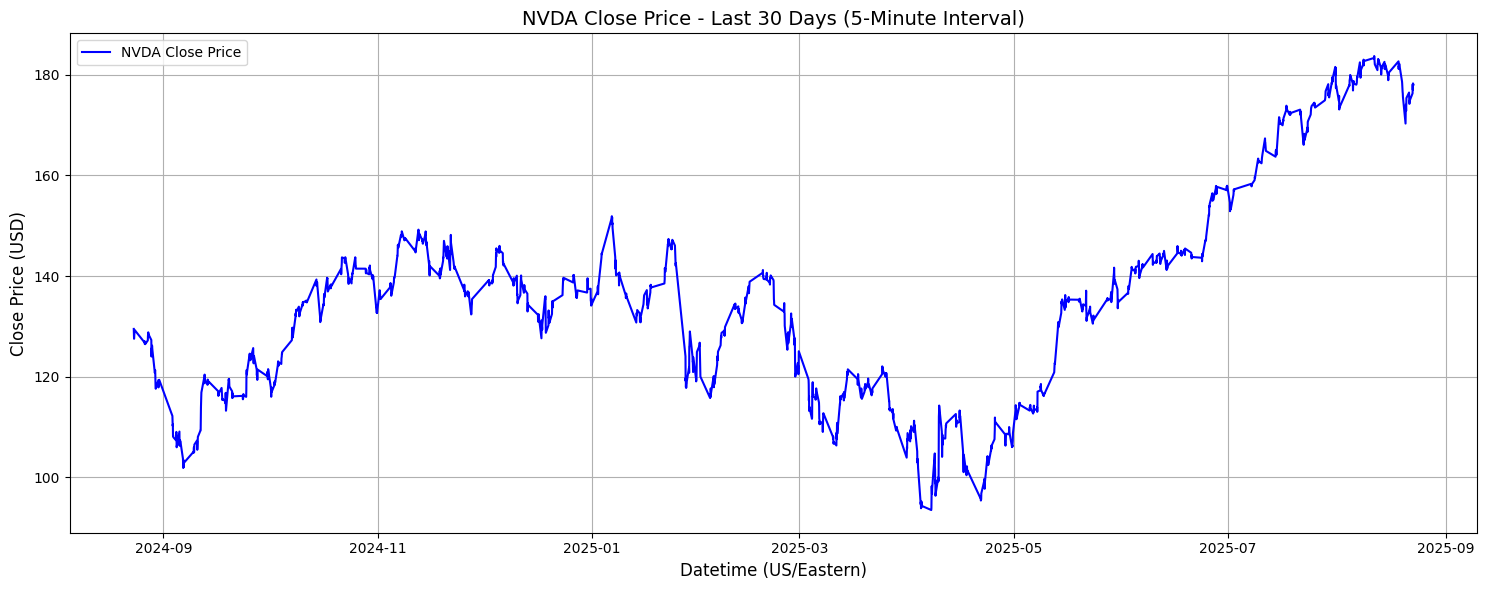

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV and parse the datetime column
df = pd.read_csv('nvda_hourly_complete_days.csv', parse_dates=['Datetime'], index_col='Datetime')

# Plot Datetime vs Close
plt.figure(figsize=(15, 6))
plt.plot(df.index, df['Close'], label='NVDA Close Price', color='blue')
plt.title('NVDA Close Price - Last 30 Days (5-Minute Interval)', fontsize=14)
plt.xlabel('Datetime (US/Eastern)', fontsize=12)
plt.ylabel('Close Price (USD)', fontsize=12)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### 1 input feature with train-test split direct forecast

Input shape: (1554, 140, 1)
Output shape: (1554, 35)
Epoch 1/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0575 - val_loss: 0.0200
Epoch 2/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0062 - val_loss: 0.0238
Epoch 3/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0063 - val_loss: 0.0336
Epoch 4/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0067 - val_loss: 0.0334
Epoch 5/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0061 - val_loss: 0.0250
Epoch 6/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0060 - val_loss: 0.0178
Epoch 7/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0059 - val_loss: 0.0228
Epoch 8/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0059 - val_loss: 0.0145
Epoch 9/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0057 - val_loss: 0.0133
Epoch 10/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0056 - val_loss: 0.0125
Epoch 11/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0052 - val_loss: 0.0234
Epoch 12/2

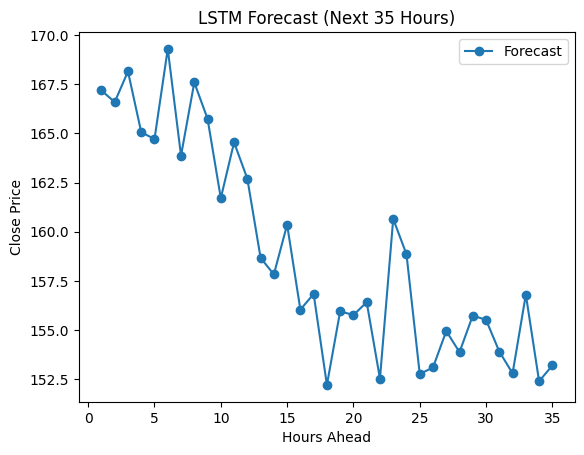

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras import Input

# ---------------- Load Data ----------------
df = pd.read_csv("nvda_hourly_complete_days.csv")
df["Datetime"] = pd.to_datetime(df["Datetime"], utc=True)
df = df.sort_values("Datetime")  # Ensure chronological order

# Use Close price (can add more features if needed)
data = df[["Close"]].values

# Scale data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(data)

# ---------------- Prepare Sequences ----------------
lookback = 20 * 7   # 20 days * 7 hours
forecast_horizon = 5 * 7   # 5 days * 7 hours

X, y = [], []
for i in range(len(scaled) - lookback - forecast_horizon):
    X.append(scaled[i:i+lookback])
    y.append(scaled[i+lookback:i+lookback+forecast_horizon].flatten())

X, y = np.array(X), np.array(y)

print("Input shape:", X.shape)
print("Output shape:", y.shape)

# ---------------- Train/Test Split ----------------
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# ---------------- Build LSTM ----------------
model = Sequential([
    Input(shape=(lookback, 1)),
    LSTM(128, activation="tanh", return_sequences=False),
    Dense(forecast_horizon)
])
model.compile(optimizer="adam", loss="mse")

# ---------------- Train ----------------
history = model.fit(X_train, y_train, epochs=20, batch_size=16,
                    validation_data=(X_test, y_test))

# ---------------- Forecast Next 5 Days (35 hours) ----------------
last_window = scaled[-lookback:]
last_window = np.expand_dims(last_window, axis=0)

pred_scaled = model.predict(last_window)
pred = scaler.inverse_transform(pred_scaled.reshape(-1, 1)).flatten()

print("Next 5*7-hour forecast:", pred)

# ---------------- Plot ----------------
plt.plot(range(1, forecast_horizon + 1), pred, marker="o", label="Forecast")
plt.title("LSTM Forecast (Next 35 Hours)")
plt.xlabel("Hours Ahead")
plt.ylabel("Close Price")
plt.legend()
plt.show()

### 5 input features with train-test split direct forecast

Input shape: (1554, 140, 5)
Output shape: (1554, 35)
Epoch 1/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0469 - val_loss: 0.0336
Epoch 2/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0061 - val_loss: 0.0156
Epoch 3/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0060 - val_loss: 0.0200
Epoch 4/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0059 - val_loss: 0.0189
Epoch 5/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0054 - val_loss: 0.0326
Epoch 6/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0058 - val_loss: 0.0196
Epoch 7/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0059 - val_loss: 0.0319
Epoch 8/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0057 - val_loss: 0.0283
Epoch 9/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0055 - val_loss: 0.0256
Epoch 10/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0052 - val_loss: 0.0247
Epoch 11/20
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0054 - val_loss: 0.0413
Epoch 12/2

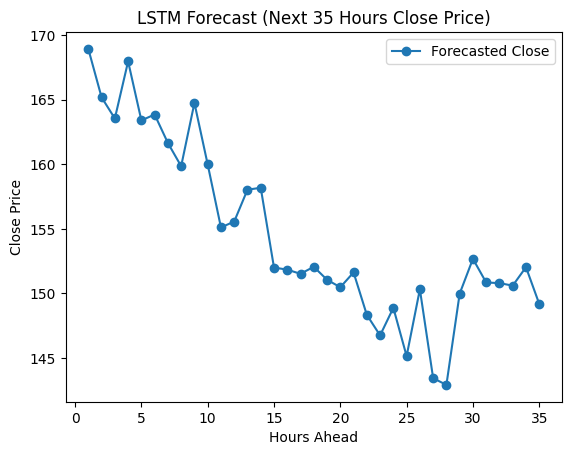

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras import Input

# ---------------- Load Data ----------------
df = pd.read_csv("nvda_hourly_complete_days.csv")
df["Datetime"] = pd.to_datetime(df["Datetime"], utc=True)
df = df.sort_values("Datetime")  # Ensure chronological order

# Use OHLCV features
data = df[["Close", "High", "Low", "Open", "Volume"]].values

# Scale all features
scaler = MinMaxScaler()
scaled = scaler.fit_transform(data)

# ---------------- Prepare Sequences ----------------
lookback = 20 * 7   # 20 days * 7 hours
forecast_horizon = 5 * 7   # 5 days * 7 hours

X, y = [], []
for i in range(len(scaled) - lookback - forecast_horizon):
    X.append(scaled[i:i+lookback])                            # shape (210, 5)
    y.append(scaled[i+lookback:i+lookback+forecast_horizon, 0])  # Close = 1st column

X, y = np.array(X), np.array(y)

print("Input shape:", X.shape)
print("Output shape:", y.shape)

# ---------------- Train/Test Split ----------------
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# ---------------- Build LSTM ----------------
model = Sequential([
    Input(shape=(lookback, 5)),
    LSTM(128, activation="tanh", return_sequences=False),
    Dense(forecast_horizon)
])
model.compile(optimizer="adam", loss="mse")

# ---------------- Train ----------------
history = model.fit(X_train, y_train, epochs=20, batch_size=16,
                    validation_data=(X_test, y_test))

# ---------------- Forecast Next 5 Days (35 hours) ----------------
last_window = scaled[-lookback:]
last_window = np.expand_dims(last_window, axis=0)

pred_scaled = model.predict(last_window)

# Inverse-transform: need to put predictions back into OHLCV shape
# Fill other features with 0s, keep predictions in Close column
dummy = np.zeros((forecast_horizon, 5))
dummy[:, 0] = pred_scaled.flatten()   # put predicted Close in 1st column

pred = scaler.inverse_transform(dummy)[:, 0]  # extract Close after inverse scaling

print("Next 5*7-hour Close forecast:", pred)

# ---------------- Plot ----------------
plt.plot(range(1, forecast_horizon + 1), pred, marker="o", label="Forecasted Close")
plt.title("LSTM Forecast (Next 35 Hours Close Price)")
plt.xlabel("Hours Ahead")
plt.ylabel("Close Price")
plt.legend()
plt.show()


### 1 input feature without train-test split direct forecast

Input shape: (1554, 140, 1)
Output shape: (1554, 35)
Epoch 1/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0747
Epoch 2/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0061
Epoch 3/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0056
Epoch 4/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0062
Epoch 5/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0057
Epoch 6/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0057
Epoch 7/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0060
Epoch 8/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0055
Epoch 9/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0053
Epoch 10/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0051
Epoch 11/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0052
Epoch 12/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0054
Epoch 13/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0053
Epoch 14/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0049
Epoch 15/20
98/98 

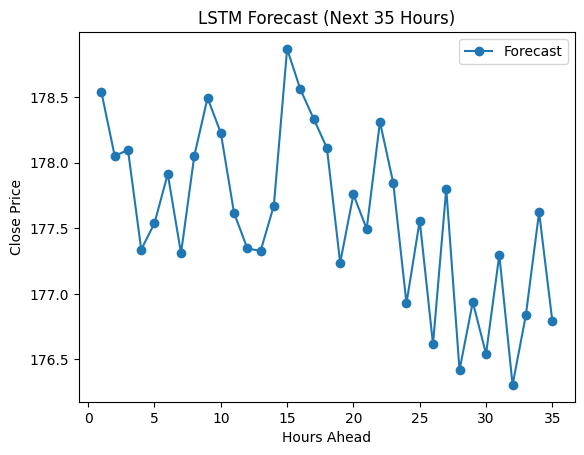

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras import Input

# ---------------- Load Data ----------------
df = pd.read_csv("nvda_hourly_complete_days.csv")
df["Datetime"] = pd.to_datetime(df["Datetime"], utc=True)
df = df.sort_values("Datetime")  # Ensure chronological order

# Use Close price (can add more features if needed)
data = df[["Close"]].values

# Scale data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(data)

# ---------------- Prepare Sequences ----------------
lookback = 20 * 7   # 20 days * 7 hours
forecast_horizon = 5 * 7   # 5 days * 7 hours

X, y = [], []
for i in range(len(scaled) - lookback - forecast_horizon):
    X.append(scaled[i:i+lookback])
    y.append(scaled[i+lookback:i+lookback+forecast_horizon].flatten())

X, y = np.array(X), np.array(y)

print("Input shape:", X.shape)
print("Output shape:", y.shape)

# ---------------- Use all data for training ----------------
X_train, y_train = X, y  # all data

# ---------------- Build LSTM ----------------
model = Sequential([
    Input(shape=(lookback, 1)),
    LSTM(128, activation="tanh", return_sequences=False),
    Dense(forecast_horizon)
])
model.compile(optimizer="adam", loss="mse")

# ---------------- Train ----------------
history = model.fit(X_train, y_train, epochs=20, batch_size=16)
# note: no validation_data

# ---------------- Forecast Next 5 Days (35 hours) ----------------
last_window = scaled[-lookback:]
last_window = np.expand_dims(last_window, axis=0)

pred_scaled = model.predict(last_window)
pred = scaler.inverse_transform(pred_scaled.reshape(-1, 1)).flatten()

print("Next 5*7-hour forecast:", pred)

# ---------------- Plot ----------------
plt.plot(range(1, forecast_horizon + 1), pred, marker="o", label="Forecast")
plt.title("LSTM Forecast (Next 35 Hours)")
plt.xlabel("Hours Ahead")
plt.ylabel("Close Price")
plt.legend()
plt.show()

### 5 input features without train-test split direct forecast

Input shape: (1554, 140, 5)
Output shape: (1554, 35)
Epoch 1/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0680
Epoch 2/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0065
Epoch 3/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0054
Epoch 4/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0049
Epoch 5/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0056
Epoch 6/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0054
Epoch 7/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0053
Epoch 8/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0054
Epoch 9/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0050
Epoch 10/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0050
Epoch 11/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0050
Epoch 12/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0056
Epoch 13/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0050
Epoch 14/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0053
Epoch 15/20
98/98 

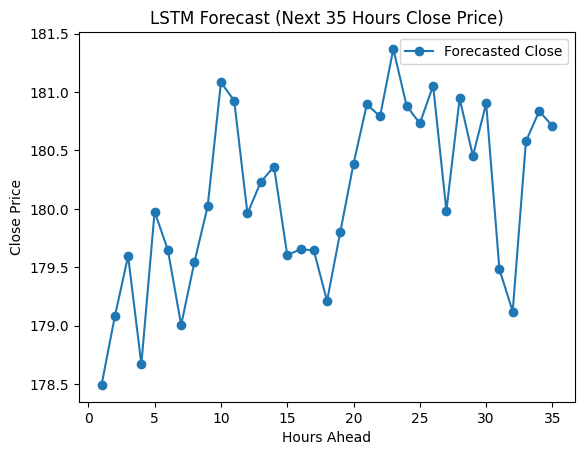

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras import Input

# ---------------- Load Data ----------------
df = pd.read_csv("nvda_hourly_complete_days.csv")
df["Datetime"] = pd.to_datetime(df["Datetime"], utc=True)
df = df.sort_values("Datetime")  # Ensure chronological order

# Use OHLCV features
data = df[["Close", "High", "Low", "Open", "Volume"]].values

# Scale all features
scaler = MinMaxScaler()
scaled = scaler.fit_transform(data)

# ---------------- Prepare Sequences ----------------
lookback = 20 * 7   # 20 days * 7 hours
forecast_horizon = 5 * 7   # 5 days * 7 hours

X, y = [], []
for i in range(len(scaled) - lookback - forecast_horizon):
    X.append(scaled[i:i+lookback])
    y.append(scaled[i+lookback:i+lookback+forecast_horizon, 0])  # Close = 1st column

X, y = np.array(X), np.array(y)

print("Input shape:", X.shape)
print("Output shape:", y.shape)

# ---------------- Use all data for training ----------------
X_train, y_train = X, y  # all data

# ---------------- Build LSTM ----------------
model = Sequential([
    Input(shape=(lookback, 5)),
    LSTM(128, activation="tanh", return_sequences=False),
    Dense(forecast_horizon)
])
model.compile(optimizer="adam", loss="mse")

# ---------------- Train ----------------
history = model.fit(X_train, y_train, epochs=20, batch_size=16)
# note: no validation_data

# ---------------- Forecast Next 5 Days (35 hours) ----------------
last_window = scaled[-lookback:]
last_window = np.expand_dims(last_window, axis=0)

pred_scaled = model.predict(last_window)

# Inverse-transform: put predictions back into OHLCV shape
dummy = np.zeros((forecast_horizon, 5))
dummy[:, 0] = pred_scaled.flatten()   # predicted Close in 1st column

pred = scaler.inverse_transform(dummy)[:, 0]  # extract Close after inverse scaling

print("Next 5*7-hour Close forecast:", pred)

# ---------------- Plot ----------------
plt.plot(range(1, forecast_horizon + 1), pred, marker="o", label="Forecasted Close")
plt.title("LSTM Forecast (Next 35 Hours Close Price)")
plt.xlabel("Hours Ahead")
plt.ylabel("Close Price")
plt.legend()
plt.show()

### 1 input feature without train-test split recursive forecast

Input shape: (1588, 140, 1)
Output shape: (1588, 1)
Epoch 1/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0396
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0010
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0011
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 9.4974e-04
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 8.1738e-04
Epoch 6/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 7.5823e-04
Epoch 7/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 7.9820e-04
Epoch 8/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 7.5897e-04
Epoch 9/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 7.6674e-04
Epoch 10/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 6.6853e-04
Epoch 11/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 7.3125e-04
Epoch 12/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 7.7848e-04
Epoch 13/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 6.8455e-04
Epoch 14/20
100/100 

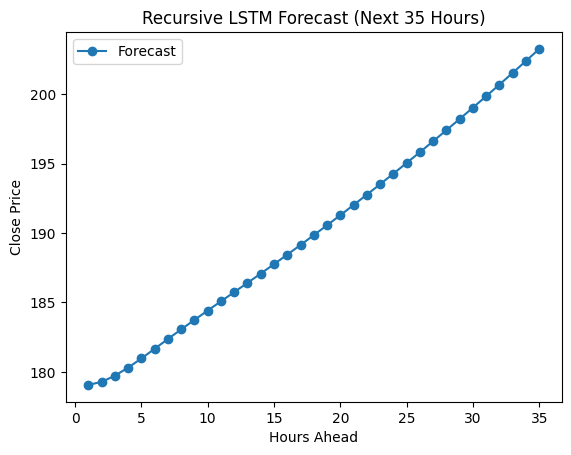

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras import Input

# ---------------- Load Data ----------------
df = pd.read_csv("nvda_hourly_complete_days.csv")
df["Datetime"] = pd.to_datetime(df["Datetime"], utc=True)
df = df.sort_values("Datetime")  # Ensure chronological order

# Use Close price (can add more features if needed)
data = df[["Close"]].values

# Scale data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(data)

# ---------------- Prepare Sequences ----------------
lookback = 20 * 7   # 20 days * 7 hours

X, y = [], []
for i in range(len(scaled) - lookback - 1):  # 1-step ahead
    X.append(scaled[i:i+lookback])
    y.append(scaled[i+lookback])

X, y = np.array(X), np.array(y)

print("Input shape:", X.shape)
print("Output shape:", y.shape)

# ---------------- Use all data for training ----------------
X_train, y_train = X, y  # all data

# ---------------- Build LSTM for 1-step prediction ----------------
model = Sequential([
    Input(shape=(lookback, 1)),
    LSTM(128, activation="tanh"),
    Dense(1)   # 1-step ahead output
])
model.compile(optimizer="adam", loss="mse")

# ---------------- Train ----------------
history = model.fit(X_train, y_train, epochs=20, batch_size=16)

# ---------------- Recursive Forecast Next 35 Hours ----------------
forecast_horizon = 5 * 7  # 35 hours
last_window = scaled[-lookback:]  # shape (lookback, 1)
predictions = []

for _ in range(forecast_horizon):
    input_window = np.expand_dims(last_window, axis=0)  # shape (1, lookback, 1)
    next_step_scaled = model.predict(input_window, verbose=0)[0, 0]  # 1-step ahead
    predictions.append(next_step_scaled)
    
    # Update window: drop first value, append predicted value
    last_window = np.vstack([last_window[1:], [[next_step_scaled]]])

# Inverse scale to get actual prices
pred = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()
print("Next 35-hour forecast (recursive):", pred)

# ---------------- Plot ----------------
plt.plot(range(1, forecast_horizon + 1), pred, marker="o", label="Forecast")
plt.title("Recursive LSTM Forecast (Next 35 Hours)")
plt.xlabel("Hours Ahead")
plt.ylabel("Close Price")
plt.legend()
plt.show()

### 5 input features without train-test split recursive forecast

Input shape: (1588, 140, 5)
Output shape: (1588,)
Epoch 1/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0263
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 8.7634e-04
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 7.5858e-04
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 7.4951e-04
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 7.0162e-04
Epoch 6/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 6.1704e-04
Epoch 7/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 6.4695e-04
Epoch 8/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 6.5458e-04
Epoch 9/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 6.4630e-04
Epoch 10/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 5.4864e-04
Epoch 11/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 5.4838e-04
Epoch 12/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 5.2681e-04
Epoch 13/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 4.9146e-04
Epoch 14/20
10

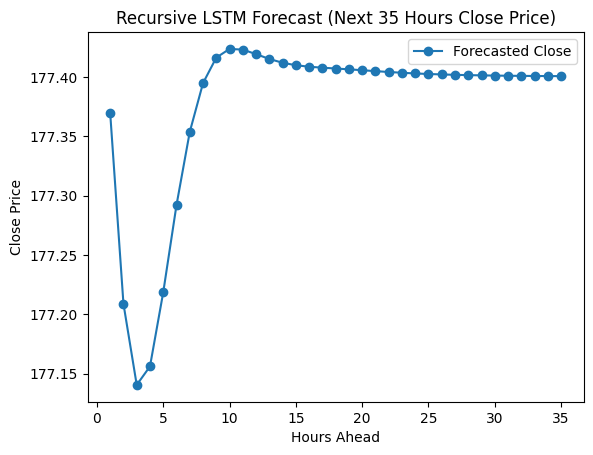

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras import Input

# ---------------- Load Data ----------------
df = pd.read_csv("nvda_hourly_complete_days.csv")
df["Datetime"] = pd.to_datetime(df["Datetime"], utc=True)
df = df.sort_values("Datetime")  # Ensure chronological order

# Use OHLCV features
data = df[["Close", "High", "Low", "Open", "Volume"]].values

# Scale all features
scaler = MinMaxScaler()
scaled = scaler.fit_transform(data)

# ---------------- Prepare Sequences ----------------
lookback = 20 * 7   # 20 days * 7 hours

X, y = [], []
for i in range(len(scaled) - lookback - 1):  # 1-step ahead
    X.append(scaled[i:i+lookback])
    y.append(scaled[i+lookback, 0])  # predict Close only

X, y = np.array(X), np.array(y)

print("Input shape:", X.shape)
print("Output shape:", y.shape)

# ---------------- Train LSTM for 1-step prediction ----------------
model = Sequential([
    Input(shape=(lookback, 5)),
    LSTM(128, activation="tanh"),
    Dense(1)   # predict 1-step Close
])
model.compile(optimizer="adam", loss="mse")

history = model.fit(X, y, epochs=20, batch_size=16)

# ---------------- Recursive Forecast Next 35 Hours ----------------
forecast_horizon = 5 * 7  # 35 hours
last_window = scaled[-lookback:]  # shape (lookback, 5)
predictions = []

for _ in range(forecast_horizon):
    input_window = np.expand_dims(last_window, axis=0)  # shape (1, lookback, 5)
    next_close_scaled = model.predict(input_window, verbose=0)[0, 0]
    predictions.append(next_close_scaled)
    
    # Update last_window for next step
    # Keep other features as zeros (or last known values) except Close
    new_row = last_window[-1].copy()  # copy last row
    new_row[0] = next_close_scaled    # update Close
    last_window = np.vstack([last_window[1:], [new_row]])

# Inverse transform to get actual Close prices
dummy = np.zeros((forecast_horizon, 5))
dummy[:, 0] = predictions
pred_close = scaler.inverse_transform(dummy)[:, 0]

print("Next 35-hour Close forecast (recursive):", pred_close)

# ---------------- Plot ----------------
plt.plot(range(1, forecast_horizon + 1), pred_close, marker="o", label="Forecasted Close")
plt.title("Recursive LSTM Forecast (Next 35 Hours Close Price)")
plt.xlabel("Hours Ahead")
plt.ylabel("Close Price")
plt.legend()
plt.show()

### 1 input feature without train-test split 5 steps at a time forecast

Input shape: (1584, 140, 1)
Output shape: (1584, 5)
Epoch 1/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0607
Epoch 2/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0021
Epoch 3/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0020
Epoch 4/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0017
Epoch 5/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0018
Epoch 6/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0016
Epoch 7/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0016
Epoch 8/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0018
Epoch 9/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0013
Epoch 10/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0015
Epoch 11/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0015
Epoch 12/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0015
Epoch 13/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0015
Epoch 14/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0012
Epoch 15/20
99/99 ━

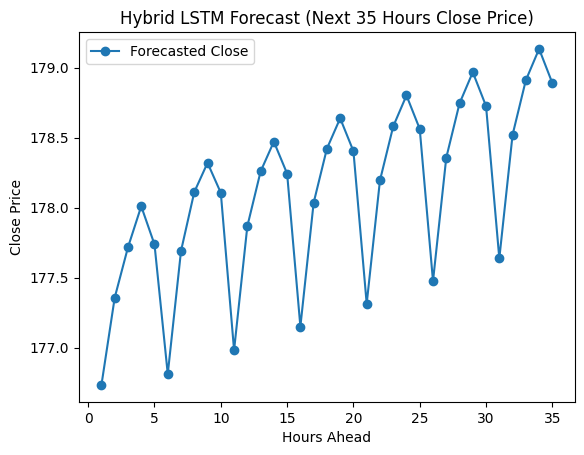

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras import Input

# ---------------- Load Data ----------------
df = pd.read_csv("nvda_hourly_complete_days.csv")
df["Datetime"] = pd.to_datetime(df["Datetime"], utc=True)
df = df.sort_values("Datetime")  # Ensure chronological order

# Use Close price only
data = df[["Close"]].values

# Scale data
scaler = MinMaxScaler()
scaled = scaler.fit_transform(data)

# ---------------- Prepare Sequences ----------------
lookback = 20 * 7   # 20 days * 7 hours
step_size = 5       # predict 5 steps at a time

X, y = [], []
for i in range(len(scaled) - lookback - step_size):
    X.append(scaled[i:i+lookback])
    y.append(scaled[i+lookback:i+lookback+step_size, 0])  # Close only

X, y = np.array(X), np.array(y)

print("Input shape:", X.shape)
print("Output shape:", y.shape)

# ---------------- Train LSTM for multi-step prediction ----------------
model = Sequential([
    Input(shape=(lookback, 1)),
    LSTM(128, activation="tanh"),
    Dense(step_size)   # predict multiple steps at once
])
model.compile(optimizer="adam", loss="mse")

history = model.fit(X, y, epochs=20, batch_size=16)

# ---------------- Hybrid Recursive Forecast ----------------
forecast_horizon = 35  # total steps to predict
last_window = scaled[-lookback:]  # shape (lookback, 1)
predictions = []

while len(predictions) < forecast_horizon:
    input_window = np.expand_dims(last_window, axis=0)
    next_steps_scaled = model.predict(input_window, verbose=0)[0]  # shape: (step_size,)
    
    # Clip if remaining steps < step_size
    remaining_steps = forecast_horizon - len(predictions)
    next_steps_scaled = next_steps_scaled[:remaining_steps]
    
    predictions.extend(next_steps_scaled)
    
    # Update last_window: drop oldest steps, append predicted steps
    for step in next_steps_scaled:
        last_window = np.vstack([last_window[1:], [[step]]])

# Inverse transform to get actual Close prices
pred_close = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()

print("Next 35-hour Close forecast (hybrid):", pred_close)

# ---------------- Plot ----------------
plt.plot(range(1, forecast_horizon + 1), pred_close, marker="o", label="Forecasted Close")
plt.title("Hybrid LSTM Forecast (Next 35 Hours Close Price)")
plt.xlabel("Hours Ahead")
plt.ylabel("Close Price")
plt.legend()
plt.show()

### 5 input features without train-test split 5 steps at a time forecast

Input shape: (1584, 140, 5)
Output shape: (1584, 5)
Epoch 1/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0483
Epoch 2/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0015
Epoch 3/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0016
Epoch 4/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0015
Epoch 5/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0016
Epoch 6/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0014
Epoch 7/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0015
Epoch 8/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0012
Epoch 9/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0014
Epoch 10/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0014
Epoch 11/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0013
Epoch 12/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0012
Epoch 13/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0011
Epoch 14/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0011
Epoch 15/20
99/99 ━

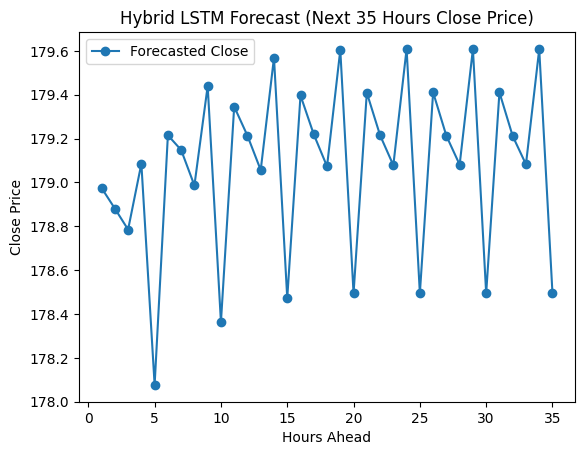

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras import Input

# ---------------- Load Data ----------------
df = pd.read_csv("nvda_hourly_complete_days.csv")
df["Datetime"] = pd.to_datetime(df["Datetime"], utc=True)
df = df.sort_values("Datetime")  # Ensure chronological order

# Use OHLCV features
data = df[["Close", "High", "Low", "Open", "Volume"]].values

# Scale all features
scaler = MinMaxScaler()
scaled = scaler.fit_transform(data)

# ---------------- Prepare Sequences ----------------
lookback = 20 * 7   # 20 days * 7 hours
step_size = 5       # predict 5 steps at a time

X, y = [], []
for i in range(len(scaled) - lookback - step_size):
    X.append(scaled[i:i+lookback])
    y.append(scaled[i+lookback:i+lookback+step_size, 0])  # Close column

X, y = np.array(X), np.array(y)

print("Input shape:", X.shape)
print("Output shape:", y.shape)

# ---------------- Train LSTM for multi-step prediction ----------------
model = Sequential([
    Input(shape=(lookback, 5)),
    LSTM(128, activation="tanh"),
    Dense(step_size)   # predict multiple steps at once
])
model.compile(optimizer="adam", loss="mse")

history = model.fit(X, y, epochs=20, batch_size=16)

# ---------------- Hybrid Recursive Forecast ----------------
forecast_horizon = 35  # total steps to predict
last_window = scaled[-lookback:]
predictions = []

while len(predictions) < forecast_horizon:
    input_window = np.expand_dims(last_window, axis=0)
    next_steps_scaled = model.predict(input_window, verbose=0)[0]  # shape: (step_size,)
    
    # Clip if remaining steps < step_size
    remaining_steps = forecast_horizon - len(predictions)
    next_steps_scaled = next_steps_scaled[:remaining_steps]
    
    predictions.extend(next_steps_scaled)
    
    # Update last_window: drop oldest steps, append predicted steps
    for step in next_steps_scaled:
        new_row = last_window[-1].copy()
        new_row[0] = step  # update Close
        last_window = np.vstack([last_window[1:], [new_row]])

# Inverse transform to get actual Close prices
dummy = np.zeros((forecast_horizon, 5))
dummy[:, 0] = predictions
pred_close = scaler.inverse_transform(dummy)[:, 0]

print("Next 35-hour Close forecast (hybrid):", pred_close)

# ---------------- Plot ----------------
plt.plot(range(1, forecast_horizon + 1), pred_close, marker="o", label="Forecasted Close")
plt.title("Hybrid LSTM Forecast (Next 35 Hours Close Price)")
plt.xlabel("Hours Ahead")
plt.ylabel("Close Price")
plt.legend()
plt.show()